In [95]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree

sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [283]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 12
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
#subset_colors2 = [cmap(0), cmap(2), cmap(5), cmap(4), cmap(8), cmap(9),]
subset_colors2 = [cmap(0), cmap(2), cmap(9), cmap(4), cmap(7), cmap(8),]
cmap_subset2 = ListedColormap(subset_colors2)

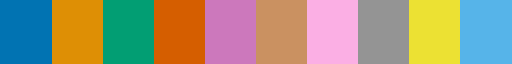

In [276]:
cmap

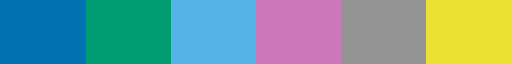

In [284]:
cmap_subset2

# Dataset

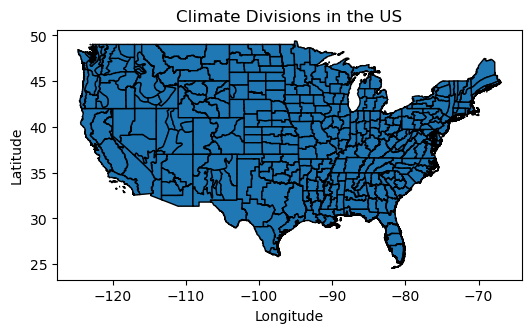

In [3]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

gdf.plot(figsize=(6, 6), edgecolor='black')
plt.title('Climate Divisions in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [4]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

In [6]:
climate_data

pcpn_jan  pcpn_feb  pcpn_mar  pcpn_apr  pcpn_may  pcpn_june  \
ID   Year                                                                
0101 1895      7.37      1.41      7.17      2.72      3.06       4.04   
     1896      2.47      7.46      6.23      4.34      2.92       4.50   
     1897      3.85      3.74     14.40      4.99      2.87       2.12   
     1898      7.07      1.34      4.43      4.29      1.86       2.61   
     1899      5.79      6.39      9.93      2.99      1.50       2.22   
...             ...       ...       ...       ...       ...        ...   
5013 2020      3.21      4.60      2.03      1.40      2.04       1.94   
     2021      5.02      5.64      3.09      2.64      2.79       2.50   
     2022      3.44      7.17      2.51      2.76      0.70       2.34   
     2023      3.71      3.83      4.87      1.88      3.27       2.06   
     2024      5.53      3.97      4.03      3.44      2.36       1.80   

           pcpn_july  pcpn_aug  pcpn_sept  pcpn_oct  ...  temp_mar  temp_apr  \
ID   Year                                            ...                       
0101 1895       4.58      4.00       3.41      2.28  ...      50.3      61.2   
     1896       3.78      1.94       2.67      1.59  ...      47.8      65.7   
     1897       3.93      3.66       0.03      1.74  ...      55.2      60.0   
     1898       5.52      3.67       2.83      3.72  ...      56.0      55.4   
     1899       6.04      3.44       0.57      1.85  ...      51.0      59.1   
...              ...       ...        ...       ...  ...       ...       ...   
5013 2020       2.76      3.24       6.04      4.18  ...      33.2      38.6   
     2021       2.09      2.61       3.53      9.21  ...      31.9      36.8   
     2022       2.96      6.06       4.25      5.75  ...      30.5      34.9   
     2023       5.39      2.87       5.34      3.34  ...      33.1      34.2   
     2024       3.74     -9.99      -9.99     -9.99  ...      29.5      35.2   

           temp_may  temp_june  temp_july  temp_aug  temp_sept  temp_oct  \
ID   Year                                                                  
0101 1895      66.8       75.8       77.0      78.1       75.2      54.3   
     1896      73.8       74.8       79.9      80.8       72.0      58.6   
     1897      66.1       78.5       80.2      77.8       74.8      64.8   
     1898      71.8       79.1       79.8      78.5       74.6      58.5   
     1899      74.3       78.8       79.9      80.8       71.0      64.2   
...             ...        ...        ...       ...        ...       ...   
5013 2020      42.2       47.4       52.0      50.9       45.5      40.9   
     2021      41.3       46.7       50.7      51.8       47.3      39.7   
     2022      39.7       46.9       50.0      51.1       48.4      41.8   
     2023      39.0       46.1       51.9      52.4       48.3      42.3   
     2024      38.4       44.7       50.3     -99.9      -99.9     -99.9   

           temp_nov  temp_dec  
ID   Year                      
0101 1895      50.1      42.1  
     1896      52.9      42.7  
     1897      50.3      43.1  
     1898      46.4      39.6  
     1899      53.0      39.9  
...             ...       ...  
5013 2020      36.3      30.6  
     2021      29.2      34.7  
     2022      37.3      33.7  
     2023      37.3      28.1  
     2024     -99.9     -99.9  

[46020 rows x 24 columns]

In [18]:
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

# Some extra code for filtering instances with large values:
#threshold = 1

# Create a boolean mask where any value in a row is greater than the threshold
#mask = ((climate_change > threshold) | (climate_change < -threshold)).any(axis=1)

# Filter the DataFrame based on the mask
#climate_change = climate_change[~mask]

<Axes: >

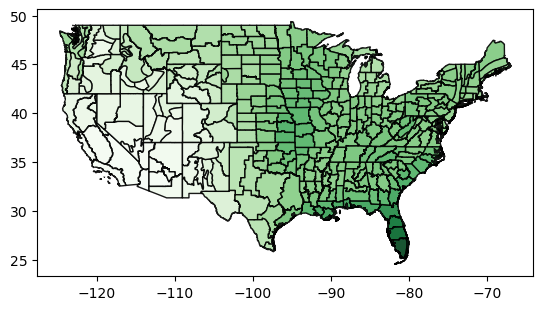

In [19]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(historical_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = historical_avg.loc[id, var]

gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

<Axes: >

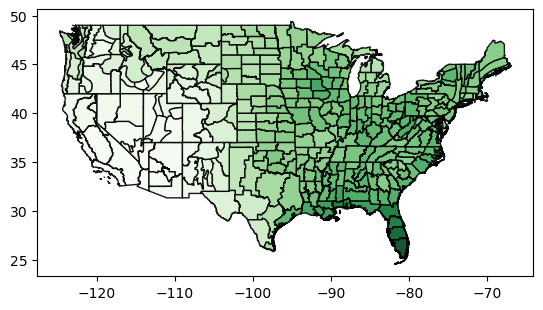

In [20]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(recent_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = recent_avg.loc[id, var]
        
gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

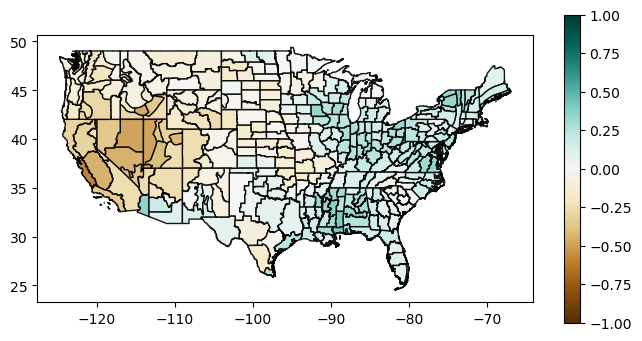

In [21]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = climate_change.loc[id, var]
        
gdf['val'] = val_array

fig,ax = plt.subplots(figsize = (8,8))
gdf.plot(column='val', cmap='BrBG', ax = ax, vmin = -1, vmax = 1, legend=False, edgecolor = 'black', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink = 0.5)

# Clustering

In [160]:
data = climate_change.to_numpy()
feature_labels = climate_change.columns

## k-means

In [161]:
k_trials = list(range(2,41))
trial_scores = [-1]*len(k_trials)
for i,k in enumerate(k_trials):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init='auto', random_state = seed).fit(data)
    kmeans_clustering = labels_to_clustering(kmeans.labels_)
    trial_scores[i] = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)
    #trial_scores[i] = silhouette_score(data, kmeans.labels_)

Text(0, 0.5, 'cost')

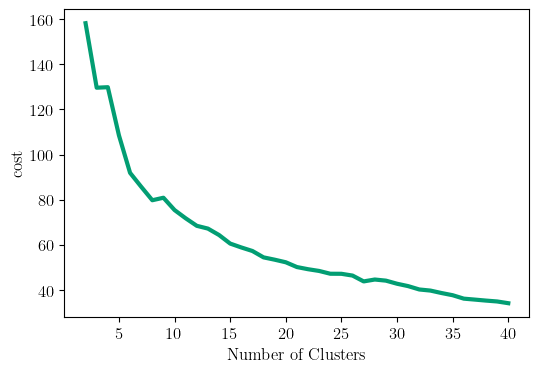

In [162]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(k_trials, trial_scores, linewidth = 3, c = cmap(2))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

In [163]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto").fit(data)

In [164]:
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

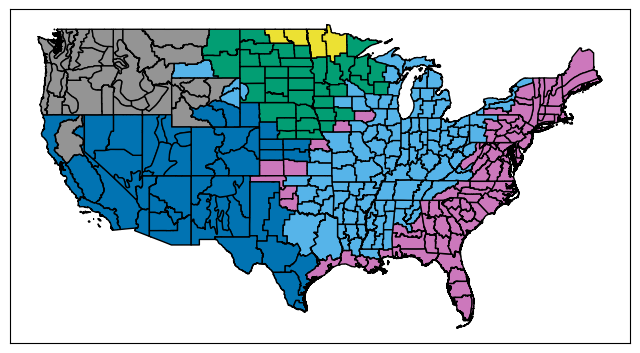

In [285]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 
plt.savefig('figures/climate_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

In [140]:
cost

79.76161227088602

### IMM

In [193]:
IMM_tree = ExTree(k, max_leaves = k)
imm_labels = IMM_tree.fit_predict(data, kmeans)
imm_clustering = labels_to_clustering(imm_labels)
imm_centers = IMM_tree.all_centers
imm_cost = kmeans_cost(data, imm_clustering, imm_centers)

([], [])

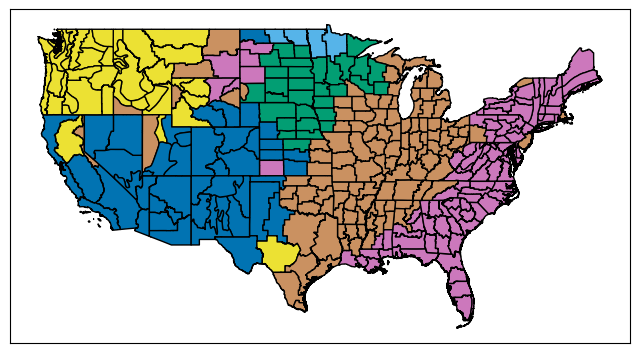

In [253]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = imm_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

### ExKMC

In [194]:
ExKMC_tree = ExTree(k, max_leaves = 2*k)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_clustering = labels_to_clustering(exkmc_labels)
exkmc_centers = ExKMC_tree.all_centers
exkmc_cost = kmeans_cost(data, exkmc_clustering, exkmc_centers)

In [195]:
exkmc_cost

93.8938629049627

<Axes: >

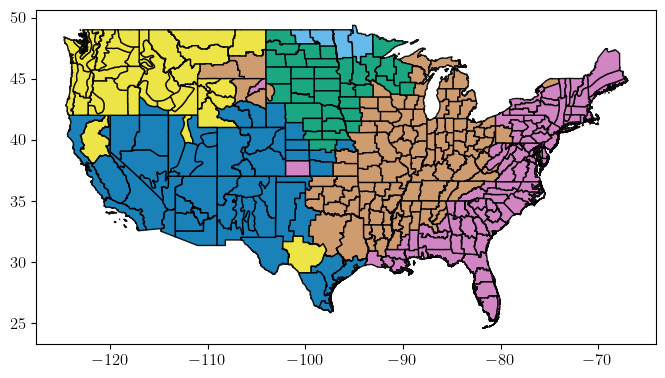

In [197]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

### Random Tree

In [257]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

random_tree_cost = np.inf
random_tree = None
random_tree_labels = None

for i in range(10000):
    random_tree_ = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree_.fit(kmeans.cluster_centers_)
    random_tree_labels_ = random_tree_.predict(data)
    random_tree_clustering_ = labels_to_clustering(random_tree_labels_)
    random_tree_centers_ = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering_])
    #rcost = kmeans_cost(data, random_tree_clustering, kmeans.cluster_centers_)
    rcost = kmeans_cost(data, random_tree_clustering_, random_tree_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost
        random_tree = random_tree_
        random_tree_labels = random_tree_labels_

C:\Users\kq146\AppData\Local\Temp\ipykernel_10372\3266807905.py:13: RuntimeWarning: Mean of empty slice.
  random_tree_centers_ = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering_])
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


([], [])

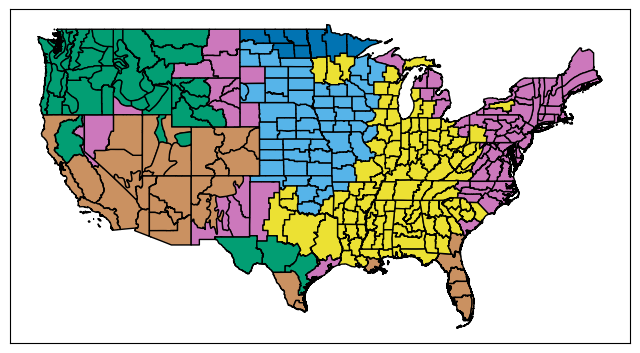

In [258]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = random_tree_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 

## Rule Clustering

In [144]:
k = 8

#### k-means Tree Partition

In [198]:
leaves = list(range(k,37))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

    cost_sum = 0
    for r in kmeans_rules:
        r.fit(data)
        mu_r = np.mean(r.satisfied_points, axis = 0)
        cost_sum += np.sum((r.satisfied_points - mu_r)**2)

    cost_by_leaves.append(cost_sum)

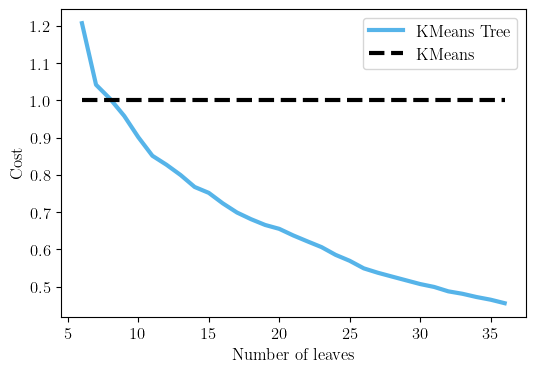

In [201]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, np.array(cost_by_leaves)/cost, linewidth = 3, label = 'KMeans Tree', c = cmap(9))
plt.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'KMeans', linewidth = 3)
plt.legend()
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
plt.savefig('figures/tree_cost.jpg', bbox_inches = 'tight', dpi = 300)

In [202]:
rule_cluster_upper_bound = 4*cost + 6*np.array(cost_by_leaves)
imm_tree_upper_bound = k * (np.log(k)**2) * cost
random_tree_upper_bound = k**2 * cost

Text(0, 0.5, 'Cost')

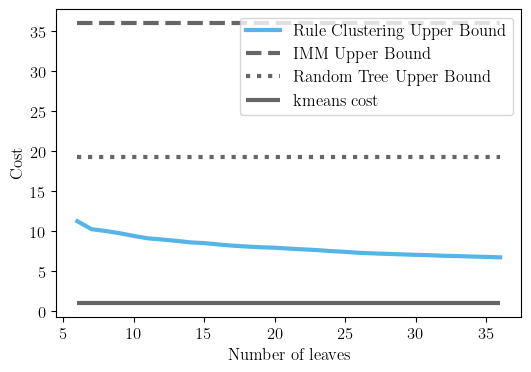

In [203]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, rule_cluster_upper_bound/cost, linewidth = 3, label = 'Rule Clustering Upper Bound', c = cmap(9))
plt.hlines(random_tree_upper_bound/cost, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'IMM Upper Bound', linewidth = 3, color = 'k', alpha = 0.6)
plt.hlines(imm_tree_upper_bound/cost, xmin = leaves[0], xmax = leaves[-1], linestyle = 'dotted', label = 'Random Tree Upper Bound', linewidth = 3, color = 'k', alpha = 0.6)
plt.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)
plt.legend()
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')

In [204]:
kmeans_tree = KMeansTree(max_leaf_nodes = 12, min_points_leaf = 1)
kmeans_tree.fit(data, feature_labels)
kmeans_tree_labels = kmeans_tree.predict(data)
tree_traverse = tree_to_rules()
kmeans_tree_rules = tree_traverse.traverse(kmeans_tree.root)
leaf_node_labels = tree_traverse.leaf_node_labels

In [205]:
tree_to_rules().traverse(kmeans_tree.root)

[(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787),
 (temp_apr <= -0.0356369820655536  ∧  temp_jan > 1.2232939474318787),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug <= 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug > 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_oct <= 0.04097642305965846),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_oct > 0.04097642305965846),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept <= -0.093328455265363),


#### Rule constrained k-means

In [206]:
rule_kmeans = KMeansRuleClustering(kmeans_tree_rules, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
data_clustering, data_labels = rule_kmeans.predict(data, return_clustering = True)

In [207]:
rule_kmeans.cost_per_iteration

[102.94377508606682]

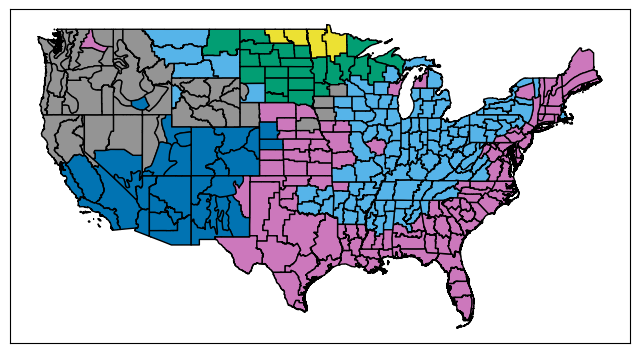

In [286]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
plt.xticks([])
plt.yticks([]) 
plt.savefig('figures/climate_rule_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

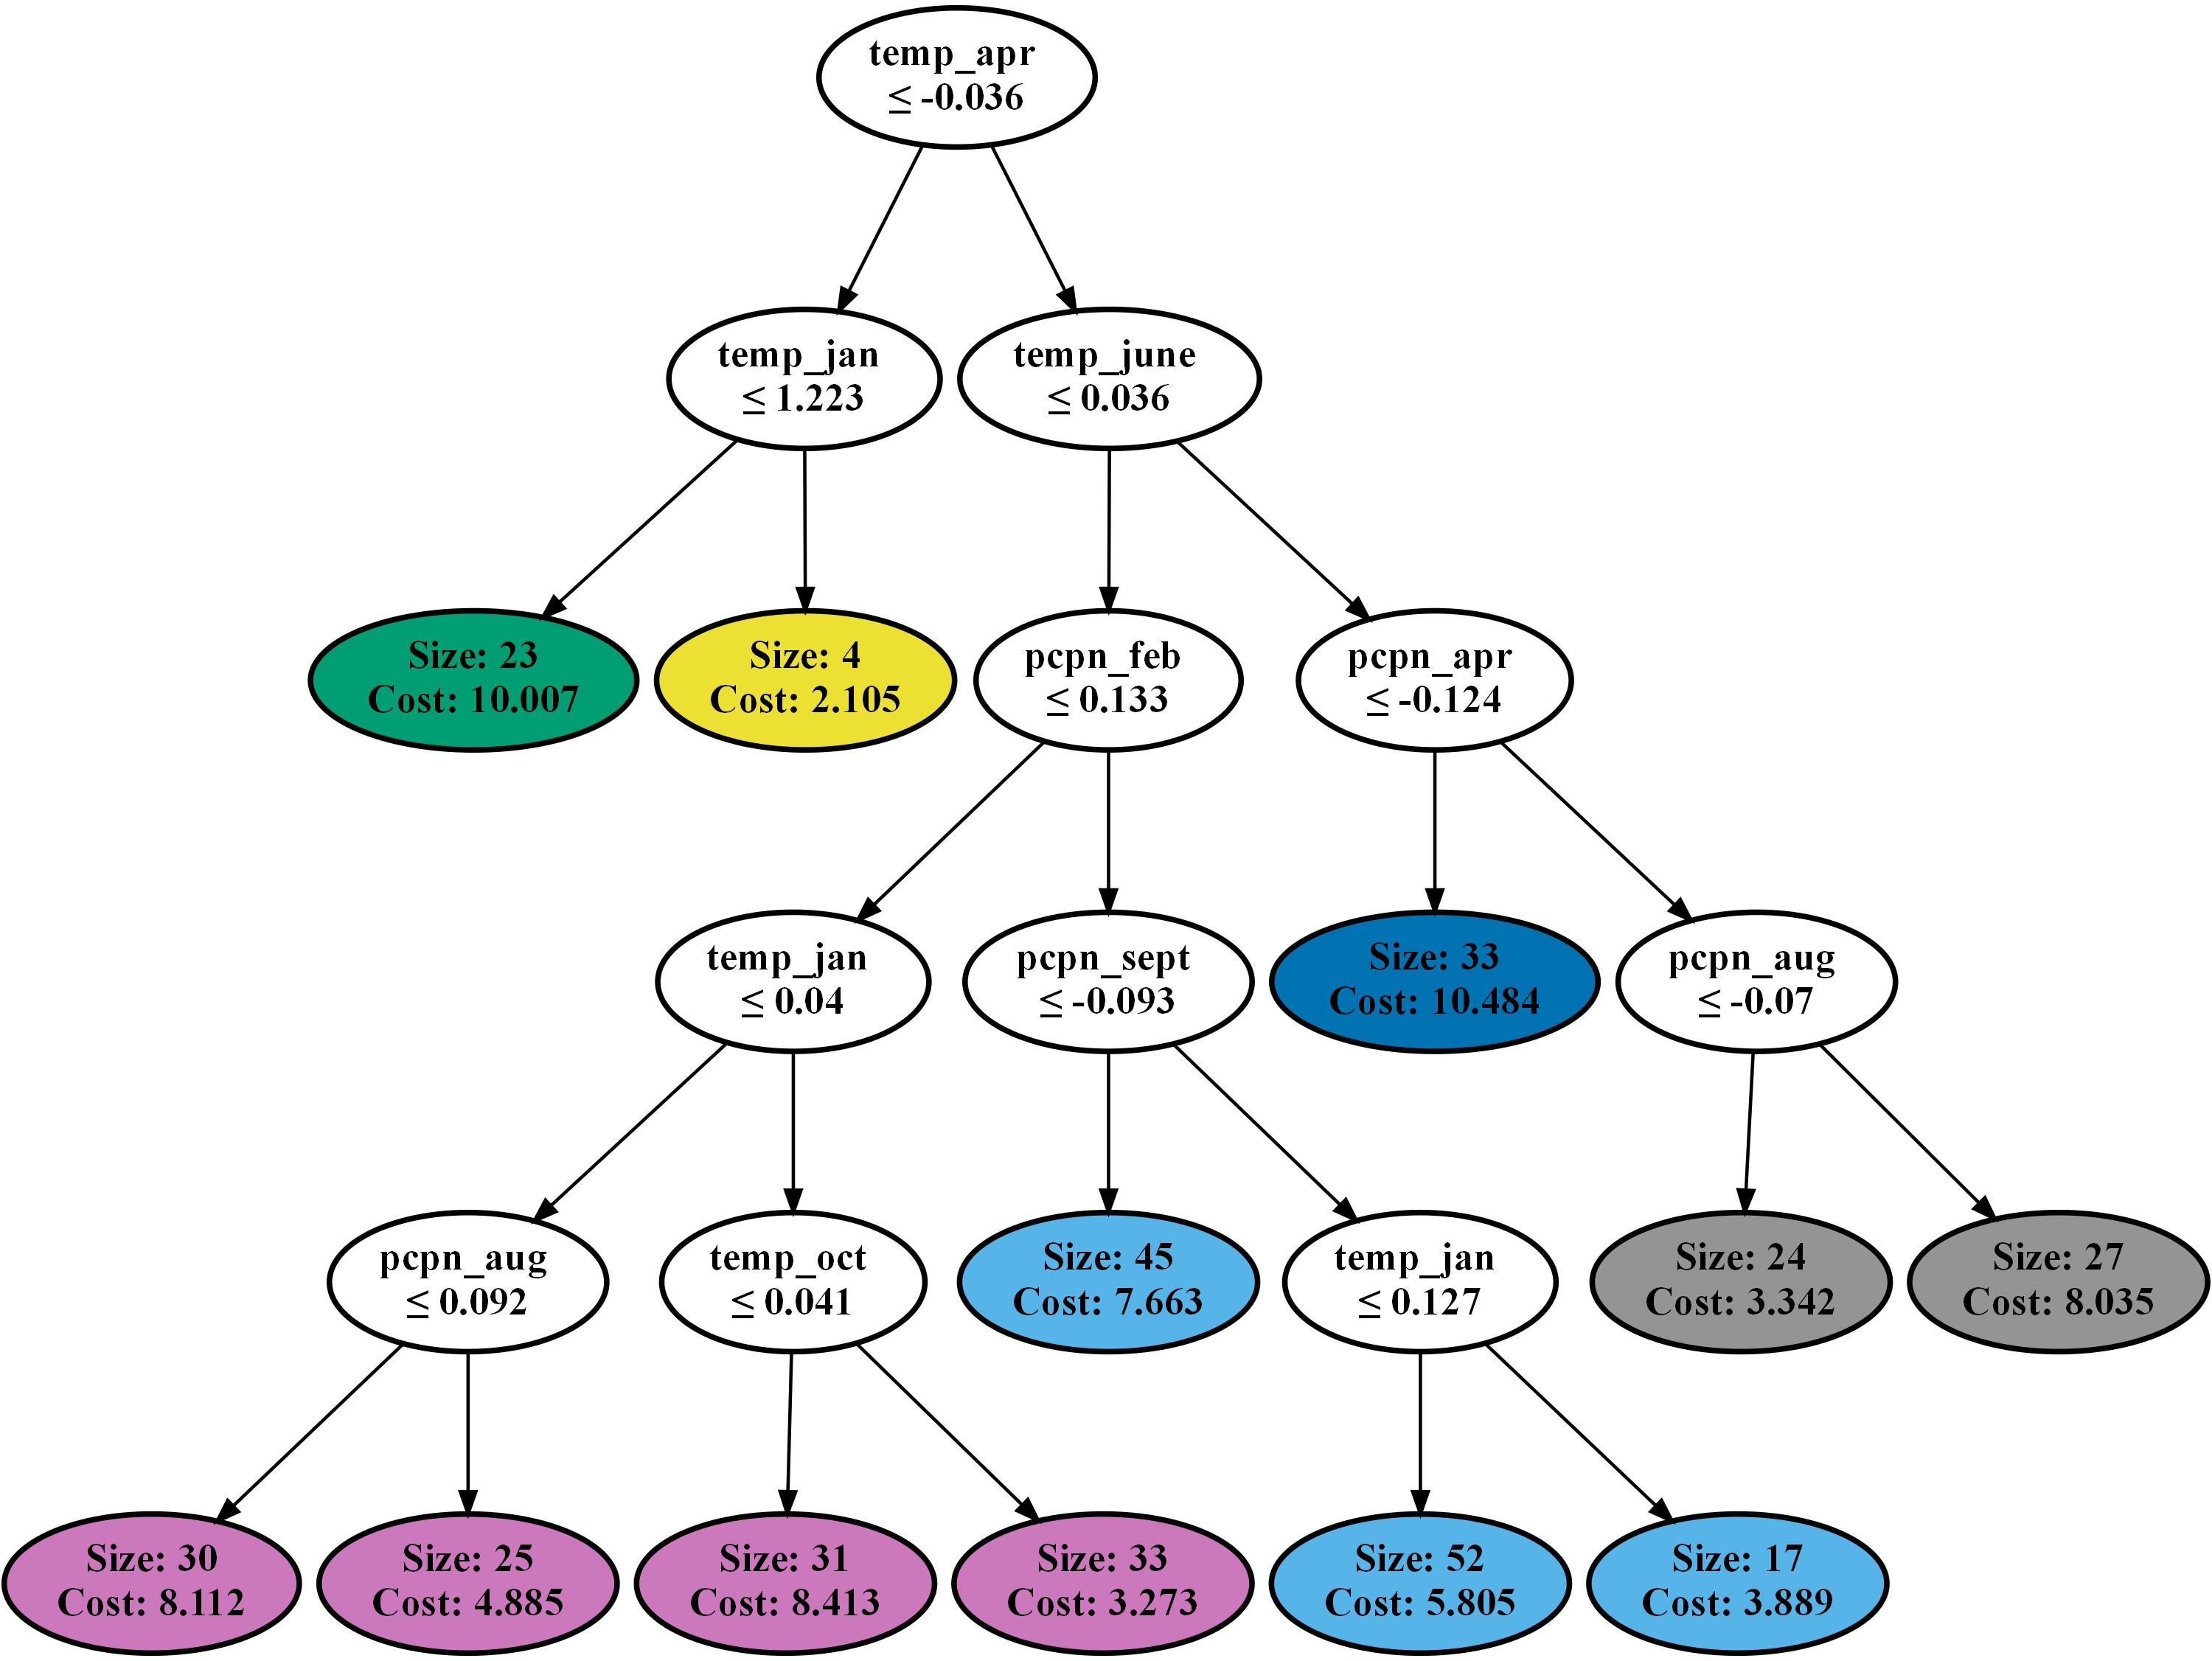

In [300]:
leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap_subset2(int(rule_labels[i])), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, output_file = 'figures/climate_tree.jpg', feature_labels = feature_labels, leaf_colors = leaf_colors)

In [155]:
print(rule_kmeans)

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_oct <= 0.04097642305965846)
THEN CLUSTER 0

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_oct > 0.04097642305965846)
THEN CLUSTER 1

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug <= 0.09240585111054267  ∧  pcpn_feb > -0.3438509460083064)  ∨  
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug > 0.09240585111054267)
THEN CLUSTER 2

IF:
(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787)
THEN CLUSTER 3

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.1333047840450

### Cost-Interpretability Tradeoff

In [266]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

leaves = list(range(k,50))
exkmc_leaves_cost = []
rule_kmeans_leaves_cost = []
rule_kmeans_random_leaves_cost = []
rule_exkmc_leaves_cost = []
rule_kmeans_iterations = []
rule_kmeans_random_iterations = []
rule_exkmc_iterations = []

for l in leaves:
    # ExKMC
    ExKMC_tree_ = ExTree(k, max_leaves = l)
    exkmc_labs_ = ExKMC_tree_.fit_predict(data, kmeans)
    exkmc_clustering_ = labels_to_clustering(exkmc_labs_)
    exkmc_centers_ = ExKMC_tree_.all_centers
    exkmc_cost_ = kmeans_cost(data, exkmc_clustering_, exkmc_centers_)
    exkmc_leaves_cost.append(exkmc_cost_)
    
    # Rule KMeans
    kmeans_tree_ = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree_.fit(data)
    kmeans_rules_ = tree_to_rules().traverse(kmeans_tree_.root)

    # With KMeans centers
    rule_kmeans_ = KMeansRuleClustering(kmeans_rules_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data)
    data_clustering_, data_labels_ = rule_kmeans_.predict(data, return_clustering = True)
    rule_kmeans_leaves_cost.append(rule_kmeans_.cost)
    rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # With random++ centers
    rule_kmeans_random_ = KMeansRuleClustering(kmeans_rules_, k_clusters = k, init = 'random++', n_init = 10, random_seed = seed)
    rule_kmeans_random_.fit(data)
    data_clustering_random_, data_labels_random_ = rule_kmeans_random_.predict(data, return_clustering = True)
    rule_kmeans_random_leaves_cost.append(rule_kmeans_random_.cost)
    rule_kmeans_random_iterations.append(rule_kmeans_random_.iterations)

    # Rule ExKMC KMeans
    exkmc_tree_ = ConvertExKMC(ExKMC_tree_.tree, data)
    exkmc_rules_ = tree_to_rules().traverse(exkmc_tree_.root)
    rule_exkmc_ = KMeansRuleClustering(exkmc_rules_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_,)
    rule_exkmc_.fit(data)
    data_clustering_exkmc_, data_labels_exkmc_ = rule_exkmc_.predict(data, return_clustering = True)
    rule_exkmc_leaves_cost.append(rule_exkmc_.cost)
    rule_exkmc_iterations.append(rule_exkmc_.iterations)

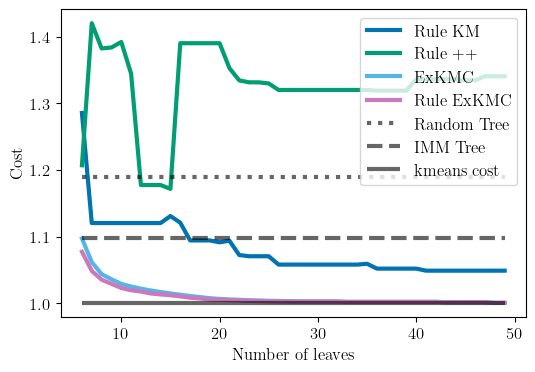

In [301]:
fig,ax = plt.subplots(figsize = (6,4))
#sns.regplot(x = leaves, y = cost_by_leaves1, order = 2, scatter_kws={'alpha':0.1}, line_kws={'linewidth': 3, 'label':'Rule Clustering (k-means)'})
#sns.regplot(x = leaves, y = cost_by_leaves2, order = 2, scatter_kws={'alpha':0.1}, line_kws={'linewidth': 3, 'label':'Rule Clustering (k-means++)'})

ax.plot(leaves, np.array(rule_kmeans_leaves_cost)/cost, linewidth = 3, label = 'Rule KM', c = cmap(0))
ax.plot(leaves, np.array(rule_kmeans_random_leaves_cost)/cost, linewidth = 3, label = 'Rule ++', c=cmap(2))
ax.plot(leaves, np.array(exkmc_leaves_cost)/cost, linewidth = 3, label = 'ExKMC', c = cmap(9))
ax.plot(leaves, np.array(rule_exkmc_leaves_cost)/cost, linewidth = 3, label = 'Rule ExKMC', c = cmap(4))

ax.hlines(random_tree_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'Random Tree', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM Tree', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
plt.savefig('figures/cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

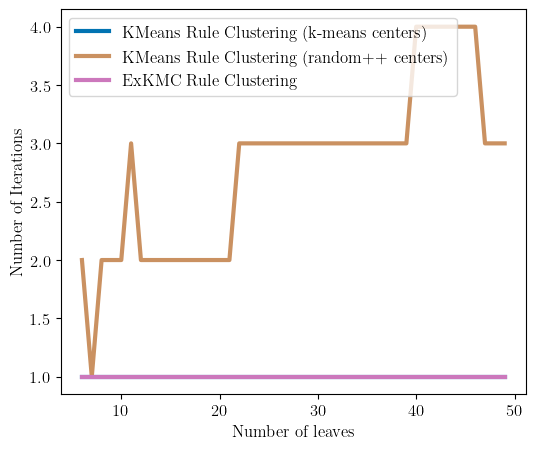

In [272]:
fig,ax = plt.subplots(figsize = (6,5))
ax.plot(leaves, rule_kmeans_iterations, linewidth = 3, label = 'KMeans Rule Clustering (k-means centers)', c = cmap(0))
ax.plot(leaves, rule_kmeans_random_iterations, linewidth = 3, label = 'KMeans Rule Clustering (random++ centers)', c = cmap(5))
ax.plot(leaves, rule_exkmc_iterations, linewidth = 3, label = 'ExKMC Rule Clustering', c = cmap(4))
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Number of Iterations')
plt.legend(loc = 'upper left')